(automate-project-yaml)=
# Create a project and its YAML file using a Git source


This example shows how to create a project in MLRun for CI/CD automation based on a remote source, for example, Git. 
The process is equivalent to using tar.gz, zip archive files.

The flow covers these steps to create a CI/CD project in MLRun:
1. [Before you start](#before-you-start)
2. [Creating a project](#creating-a-project)
2. [Setting a project source: remote or archive](#setting-a-project-source-either-remote-or-archive)
3. [Setting and running the function using Git source code](#setting-and-running-the-function-using-git-source-code)
4. [Setting the workflow](#setting-the-workflow)
4. [Running the workflow](#running-the-workflow)
5. [Setting and registering the artifacts](#setting-and-registering-the-artifacts)
6. [Create and save the project YAML](#create-and-save-the-project-yaml)
7. [Creating and pushing changes to your Git repo or archive file](#creating-and-pushing-changes-to-your-git-repo-or-archive-file)

## Before you start

Install MLRun. If MLRun is not installed use ``pip install mlrun==<mlrun server version>`` or <br>``sh align_mlrun.sh`` 
(the default MLRun installer that automatically installs the server version).

In [1]:
import mlrun

Before running this notebook, clone the git repo to your local machine.

In [2]:
# delete the clone folder if exists
!rm -rf ./clone

In [3]:
# clone repo to your local machine
!git clone https://github.com/your repo ./clone

Cloning into './clone'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 209 (delta 118), reused 129 (delta 53), pack-reused 0
Receiving objects: 100% (209/209), 162.20 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Creating a project

**Prerequisites**:
- Your repo or archive file contains python code files that are ready to run.
- You either cloned your repo or extracted your files to the project context in your local machine so you can start 
developing and running your function in MLRun. The code source file is usually stored under a folder named `./src` in the 
project context, for example: `./project-context/src/data_fetch.py`
However, if your files are already compatibile for running with MLRun, you do not need to clone or extract the files.

In [4]:
# Create a new project or load it from DB
project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./clone')

> 2023-05-17 09:04:46,772 [info] loaded project new-ci-cd-proj from MLRun DB


or:

```
# load from a private repo
# project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./',init_git=True,secrets={"GIT_TOKEN":<github-token>})
```

See more details in {py:class}`~mlrun.projects.get_or_create_project` and {ref}`secrets`.

When you create a new project, MLRun creates a light project YAML, for example: 
````
kind: project
metadata:
  name: new-ci-cd-proj
  created: '2022-06-30T09:41:05.612000'
spec:
  functions: []
  workflows: []
  artifacts: []
  desired_state: online
status:
  state: online
````

As you proceed, more details are added to the project YAML.

## Setting a project source, either remote or archive 

Define the project the source, and optionally `pull_at_runtime` flag value, and the project working dir, and add them to 
the `project.yaml` by using the {py:class}`~mlrun.projects.MlrunProject.set_source` method.   
To copy these values also to the functions spec, set `with_repo=True` in the `project.set_function` method. 
Then, when running functions on the runtime/cluster (local=False) it  runs the code files from the remote source.

- `with_repo=True` adds the entire git/archive repo code into the function-destination container during build or runtime 
and does not require a building a new image. This is useful when developing, but for production it’s preferable to build 
the image with the code.
- If `with_repo` is not set to `True` (default), you need to deploy the functions with `function.deploy()` to build a 
container.

In [5]:
# Add the git branch or references to the source e.g.: 'git://url/org/repo.git#<branch-name or refs/heads/..>'.
source = 'git://github.com/GiladShapira94/example-ci-cd.git#master'

In [6]:
# Set the project source
project.set_source(source=source,pull_at_runtime=True)

See more about `pull_at_runtime` in [Loading the code from container vs. loading the code at runtime](./git-best-practices.html#loading-the-code-from-container-vs-loading-the-code-at-runtime).

## Setting and running the function using Git source code

Verify the [Perequisites](#prerequisites).

In this section:
- [Setting the project's functions](#setting-the-projects-functions)
- [Fetching the function's data](#fetching-the-functions-data)
- [Running the function](#running-the-function)
- [Training the function](#training-the-function)
- [serving the function](#serving-the-function)

### Setting the project's functions

To set the function's definitions, use the {py:class}`~mlrun.projects.MlrunProject.set_function` method. 
This sets the function's metadata in the project YAML, for example: 
function source (YAML, py, ipynb, function object), name of the function, function handler, function image, 
function kind, and function requirements.

See more details in {py:class}`mlrun.projects.MlrunProject.set_function`.

### Fetching the function's data

```{admonition} Using tags for Git releases
This example includes a `tag` value that is used as the Git tag for the release after completing the development. The tag 
must be added manually to the function.
```

In [7]:
# Set data_fetch function to the project.yaml file
project.set_function(func='./src/data_fetch.py',name='data-fetch',handler='data_fetch',kind='job',image='mlrun/mlrun',with_repo=True,tag="v3")

### Running the function

After you set the function in the project, get the function object with the 
{py:class}`~mlrun.projects.MlrunProject.get_function` method.

```{admonition} Change the function spec with get_function
You can use the `get_function` method to both get the function object, and change the function spec. For example, if you
change the function resources and then run the function, it runs with those those changes (and the changes are stored in 
the project object cache).
```
```
data_fetch_func = mlrun.get_function('data-fetch')
data_fetch_func.with_requests(mem='1G',cpu=3)
data_fetch_run = project.run_function('data-fetch')
```

Run the function using the {py:class}`~mlrun.projects.MlrunProject.run_function` method both to 
[run jobs locally](#running-the-function-locally) 
and on the [runtime/cluster](#Running-the-function-remotely-on-your-cluster), as long as there are no requirements. If 
there are any requirements you need to build a new 
image before you run a function. See moew details in {ref}`build-function-image`

#### Running the function locally

Use the code files from your project context folder on your local machine (`local=True`).

In [8]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=True)

> 2023-05-17 09:04:46,993 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'a6e5cc8f573e41f6ae6ef1c049b6e50a', 'db': 'http://mlrun-api:8080'}


> 2023-05-17 09:04:50,355 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


#### Running the function remotely on your cluster

Use the code files from the remote project source (`local=False`).

In [9]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=False)

> 2023-05-17 09:04:50,395 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '860b9700cd3f4724a0669cb7c9732beb', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:04:50,649 [info] Job is running in the background, pod: data-fetch-data-fetch-qd874
final state: completed


> 2023-05-17 09:05:03,834 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [10]:
data_fetch_run.outputs

{'train-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_train-dataset:860b9700cd3f4724a0669cb7c9732beb',
 'test-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_test-dataset:860b9700cd3f4724a0669cb7c9732beb'}

In [11]:
data_fetch_run.artifact('train-dataset').as_df().sample(3)

0         1         2         3         4         5         6  \
14  0.655400  1.357176 -0.380252  2.236612  0.102893 -0.038678  0.101061   
27  0.834107  0.572216 -0.872751  0.519342 -1.101798  0.259935  0.398852   
79 -2.040370  3.446461 -0.269668 -0.875862  1.347329  1.412033  0.764714   

           7         8         9  ...        11        12        13        14  \
14  1.555770  1.116734  0.146883  ... -2.132336  0.739735  0.452615  0.299427   
27 -0.299485  0.821154  0.018271  ... -1.634293 -0.618584  1.354337 -1.136238   
79  2.161531  0.390874 -0.900138  ... -0.904111  2.640541 -2.483898 -1.619484   

          15        16        17        18        19  label  
14  0.683967 -0.089078  0.609046 -0.895865 -0.578405      1  
27  1.248243 -0.593805  0.266741  1.180665  1.212383      1  
79 -3.676358  0.704040 -3.192003  1.669527  0.782062      1  

[3 rows x 21 columns]

### Training the function

In [12]:
project.set_function(func='./src/train.py',name='train',handler='train',kind='job',image='mlrun/mlrun',with_repo=True,tag="v3")

In [13]:
train_run = project.run_function(function='train',inputs={'train_data':data_fetch_run.outputs['train-dataset'],'test_data':data_fetch_run.outputs['test-dataset']})

> 2023-05-17 09:05:04,113 [info] Storing function: {'name': 'train-train', 'uid': '423d664e6e684b1fb9acc9e62189d5b4', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:05:04,362 [info] Job is running in the background, pod: train-train-7z8z8
final state: completed


> 2023-05-17 09:05:25,610 [info] run executed, status=completed: {'name': 'train-train'}


### Serving the function

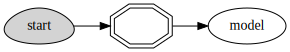

In [14]:
# Create a serving function object
serving = mlrun.new_function(name="serving", kind="serving", image="mlrun/mlrun",tag="v3")

# Add a model to the model serving function object
serving.add_model(key='model',model_path=train_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')

# Plot the serving graph
serving.spec.graph.plot(rankdir="LR")

In [15]:
# Save the function spec into a .yaml file and register it in the project
serving.export(target=f"./{project.context}/function_spec/serving.yaml")
project.set_function(func="./function_spec/serving.yaml", name="serving")

> 2023-05-17 09:05:25,815 [info] function spec saved to path: ././clone/function_spec/serving.yaml


```{admonition} CI/CD configuration considerations
- When creating a serving function, the function spec contains metadata of the function steps or the serving function 
models. Therefore, you need to create a function.yaml file by using the {py:class}`~mlrun.runtimes.BaseRuntime.export` 
method that exports the function object to a yaml file (that is saved in the function_spec folder). Then set the function 
with this yaml file. This approach saves all of the function spec for future deployments.
For example:<br>
      ````
       <function object>.export('./model_training.yaml')
       project.set_function(
           func="training.yaml",name='training',with_repo=True,kind='serving')
      ````
- Additionally, if you want to change the default function spec values, e.g. resources, node-selector and more, and want to 
make this change constant you need to create a yaml function file and use the yaml function in the `set_function` method.
- When setting a nuclio function, the function handler is a combination of the `file_name::function_handler`, for example:
      ```
      project.set_function(name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun',with_repo=True)
      ```
```

To deploy a remote function, e.g. serving and nuclio kinds, use the {py:class}`~api/mlrun.projects.deploy_function` method.

In [16]:
# Serve the function
serving_func = project.deploy_function(function='serving',models=[{'key':'model','model_path':train_run.outputs["model"], 'class_name':'mlrun.frameworks.sklearn.SklearnModelServer'}])

> 2023-05-17 09:05:25,839 [info] Starting remote function deploy
2023-05-17 09:05:26  (info) Deploying function
2023-05-17 09:05:26  (info) Building
2023-05-17 09:05:26  (info) Staging files and preparing base images
2023-05-17 09:05:26  (info) Building processor image
2023-05-17 09:06:26  (info) Build complete
2023-05-17 09:06:34  (info) Function deploy complete
> 2023-05-17 09:06:37,264 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['new-ci-cd-proj-shapira-serving-v3-new-ci-cd-proj-shapira.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [17]:
my_data = '''{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}'''

In [18]:
serving_func.function.invoke('/',my_data)

> 2023-05-17 09:06:37,342 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080/'}


{'id': '8ca4f4ef-7765-4d50-8a43-1e77a15e433f',
 'model_name': 'model',
 'outputs': [1]}

## Setting the workflow

After you completed developing your functions (in this example: `data_fetch`, `training`, and `serving`), 
continue with creating a workflow that runs those functions serially. For more information about workflows and an 
example of a workflow.py file, see {ref}`build-run-workflows-pipelines`.

To set a workflow to a project, use the {py:class}`~mlrun.projects.MlrunProject.set_workflow` method. This method adds or 
updates a workflow, and specifies a name and the code path in the project.yaml file

This example adds a workflow named main that points to a file located in ./< project-context >/src/workflow.py

In [19]:
project.set_workflow('main','./src/workflow.py')

## Running the workflow
To run the workflow, use the {py:class}`~mlrun.projects.MlrunProject.run` method.  With this method you can run a workflow 
or schedule a workflow using kubeflow pipelines by specifing the workflow name or the workflow file path.
This workflow runs all of the functions that are included in the project.

To specify running remotel, use `remote:local` or `remote:kfp`.

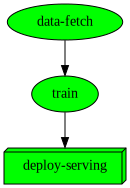

626a345a-b67f-4eb0-9a3b-4850185ada10

In [20]:
# Run the workflow named main and wait for pipeline completion (watch=True)
project.run('main',watch=True,engine="remote:kfp")

### Running a scheduled workflow

For more information about scheduling workflows, see {ref}`scheduled-jobs`.

In [21]:
project.run('main',watch=True,schedule='0 * * * *')

> 2023-05-17 09:09:34,482 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-05-17 09:09:34,485 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-05-17 09:09:34,489 [info] Storing function: {'name': 'main', 'uid': '88a2eecd5cd14c339529f2c7ced3a011', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:09:34,854 [info] task schedule modified: {'schedule': '0 * * * *', 'project': 'new-ci-cd-proj-shapira', 'name': 'main'}


## Setting and registering the artifacts

To register artifacts to a project, use the {py:class}`~mlrun.projects.MlrunProject.set_artifact` method. By adding/setting an artifact in the project spec, they are registered upon loading the project. 
In general, use this method when you want to register an artifact when loading a project, for example:
* You developed a model artifact in the development system and you want to use this model file in production.
* There are artifacts you want to register by default when you load or create a project.

```{admonition} Register artifacts from one environment to another
To register artifacts between different environments, for example dev and production, you must upload your artifacts to a remote storage e.g. S3. You can change your project artifact path using MLRun or the MLRun UI, for example:
```
```
project.artifact_path='s3:<bucket-name/..'
```

In [22]:
# get the model object to register
model_obj = project.get_artifact('model')

In [23]:
#print a target path
print(model_obj.target_path)

v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/


In [24]:
#print model file
model_obj.model_file

'model.pkl'

In [25]:
# register the model artifact to the project
project.set_artifact(key='model-test',artifact=mlrun.artifacts.ModelArtifact(model_file=model_obj.model_file),target_path=model_obj.target_path)

```{admonition} Artifact types
By default, the artifact type is equal to mlrun.artifacts.Artifact(). To specify different types, use the relevant artifact 
object. Then you can specify specific parameters to the artifact object type. The artifact types are:
```
    "dir": mlrun.artifacts.DirArtifact,
    "link": mlrun.artifacts.LinkArtifact,
    "plot": mlrun.artifacts.PlotArtifact,
    "chart": mlrun.artifacts.ChartArtifact,
    "table": mlrun.artifacts.TableArtifact,
    "model": mlrun.artifacts.ModelArtifact,
    "dataset": mlrun.artifacts.DatasetArtifact,
    "plotly": mlrun.artifacts.PlotlyArtifact,
    "bokeh": mlrun.artifacts.BokehArtifact,
```
```

### Registering the runtime values together with their artifact s
When MLRun creates an artifact there are values that are processed in runtime e.g. dataset preview or model metrics. These 
values are stored in the artifact spec. If you want to store the artifact spec for registering the artifact with those 
values, export the artifact object to a folder named `./artifacts` and set the artifact using the artifact.yaml file. For example:

```
model_obj = project.get_artifact('model')
model_obj.export(./artifact/model_artifact.yaml)
project.set_artifact(key='model',artifact='./model_artifact.yaml')
```

## Create and save the project YAML

The project YAML contains metadata about the project, for example, all the functions set to the project, the artifacts, and the workflow. When you load the project, it loads with all of these functions, artifacts, and workflow.

In general, MLRun uses this metadata to create objects, for example function objects, and then uses those objects to 
run the functions.

In [26]:
print(project.to_yaml())

kind: project
metadata:
  name: new-ci-cd-proj-shapira
  created: '2023-05-17T08:51:02.127000'
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
    tag: v3
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
    tag: v3
  - url: ./function_spec/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-ci-cd-proj-shapira
      key: model-test
    spec:
      target_path: v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#master
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/master
  load_source_on_run: true
  desired_state: onl

To export the project content to yaml file (saved in the project context) and save the project in the database, use the {py:class}`~mlrun.projects.MlrunProject.save` method.

In [27]:
# Export the yaml file and save the project
project.save()

## Creating and pushing changes to your Git repo or archive file

### Creating a Git remote

If you do not clone any files and you do not have any git remotes configured in your local folder you can use {py:class}`mlrun.projects.MlrunProject.create_remote`. This method creates a git remote and adds the remote to the project as the project source.

For example:
```
project.create_remote(url='https://github.com/mlrun/example-ci-cd.git',name='mlrun-remote',branch='master')
```

### Pushing changes to the Git repo

After you made changes in your code, push your project context to GitHub repo using {py:class}`~mlrun.projects.MlrunProject.push`.
```
project.push(branch='master',message='update',add=['project.yaml','./src/data_fetch.py','./src/serving.yaml','./src/train.py','./src/workflow.py'])
```